# Computing Galactic Orbits of Stars with Gala

## Authors
Adrian Price-Whelan, Stephanie T. Douglas

## Learning Goals
* Query the Gaia data release 2 catalog to retrieve data for a sample of well-measured, nearby stars
* Define high-mass and low-mass stellar samples using color-magnitude selections
* Calculate orbits of the high-mass and low-mass stars within the Galaxy to show that the typically younger stars (high-mass) have smaller vertical excursions

## Keywords
coordinates, astroquery, gala, galactic dynamics, astrometry, matplotlib, scatter plot, histogram


## Companion Content
Astropy Docs: [Description of the Galactocentric frame in astropy coordinates](
http://docs.astropy.org/en/latest/generated/examples/coordinates/plot_galactocentric-frame.html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py)

## Summary

We will use data from the [Gaia mission](https://www.cosmos.esa.int/web/gaia) to get sky positions, distances (parallaxes), proper motions, and radial velocities for a set of stars that are close to the Sun. We will then transform these observed, heliocentric kinematic measurements to Galactocentric Cartesian coordinates and use the positions and velocities as initial conditions to compute the orbits of these stars in the galaxy using the [gala](http://gala.adrian.pw) Python package. We will compare the orbits of high-mass main sequence (i.e. young) stars to the orbits of lower-mass main sequence stars to show that young stars have smaller vertical amplitudes.

## Installing Dependencies

This tutorial depends on the Astropy affiliated packages `gala` and `astroquery`. Both of these packages can be pip-installed with:

    pip install gala astroquery

## Imports

In [2]:
# astropy imports
import astropy.coordinates as coord
from astropy.table import QTable
import astropy.units as u
from astroquery.gaia import Gaia

# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

## Scientific Background

[The Gaia mission](https://www.cosmos.esa.int/web/gaia/) is an ESA mission that aims to measure the 3D positions and velocities of a large number of stars throughout the Milky Way. The primary mission objective is to enable studying the formation, structure, and evolutionary history of our Galaxy by measuring astrometry (sky position, parallax, and proper motion) for about 2 billion stars brighter than the Gaia $G$-band photometric magnitude $G \lesssim 21$. By end of mission (~2022), Gaia will also provide multi-band photometry and low-resolution spectrophotometry for these sources, along with radial or line-of-sight velocities for a subsample of about 100 million stars.

In April 2018, Gaia publicly released its first major catalog of data — data release 2 or DR2 — which provides a subset of these data to anyone with an internet connection. In this tutorial, we will use astrometry, radial velocities, and photometry for a small subset of DR2 to study the kinematics of different types of stars in the Milky Way.

## Using `astroquery` to retrieve Gaia data

We'll start by querying the [Gaia science archive](http://gea.esac.esa.int/archive/) to download astrometric and kinematic data (parallax, proper motion, radial velocity) for a sample of stars near the Sun. We'll use data exclusively from [data release 2 (DR2)](https://www.cosmos.esa.int/web/gaia/data-release-2) from the *Gaia* mission. For the demonstration here, let's grab data for a random subset of 4096 stars within a distance of 100 pc from the Sun that have high signal-to-noise astrometric measurements.

To perform the query and to retrieve the data, we'll use the *Gaia* module in the [astroquery](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html) package, `astroquery.gaia`. This module expects us to provide an SQL query to select the data we want (technically it should be an [ADQL](https://gea.esac.esa.int/archive-help/adql/index.html) query, which is similar to SQL but provides some additional functionality for astronomy; to learn more about ADQL syntax and options, [this guide](https://www.gaia.ac.uk/data/gaia-data-release-1/adql-cookbook) provides an introduction). We don't need all of the columns that are available in DR2, so we'll limit our query to request the sky position (`ra`, `dec`), parallax, proper motion components (`pmra`, `pmdec`), radial velocity, and magnitudes (`phot_*_mean_mag`). More information about the available columns is in the [Gaia DR2 data model](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html). 

To select stars that have high signal-to-noise parallaxes, we'll use the filter ``parallax_over_error > 10`` to select stars that have small fractional uncertainties. We'll also use the filter ``radial_velocity IS NOT null`` to only select stars that have measured radial velocities.

In [3]:
query_text = '''SELECT TOP 4096 ra, dec, parallax, pmra, pmdec, radial_velocity,
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr2.gaia_source
WHERE parallax_over_error > 10 AND
    parallax > 10 AND
    radial_velocity IS NOT null
ORDER BY random_index
'''

We now pass this query to the `Gaia.launch_job()` class method to create an anonymous job in the `Gaia` science archive to run our query. To retrieve the results of this query as an Astropy `Table` object, we then use the `job.get_results()` method. Note that you may receive a number of warnings (output lines that begin with ``WARNING:``) from the ``astropy.io.votable`` package — these are expected, and it's OK to ignore these warnings (the `Gaia` archive returns a slightly invalid VOTable).

In [4]:
# Note: the following lines require an internet connection, so we have 
# provided the results of this query as a FITS file included with the 
# tutorials repository. If you have an internet connection, feel free
# to uncomment these lines to retrieve the data with `astroquery`:
# job = Gaia.launch_job(query_text)
# gaia_data = job.get_results()
# gaia_data.write('gaia_data.fits')

In [5]:
gaia_data = QTable.read('gaia_data_sample2.fits')

The `data` object is now an Astropy `Table` called `gaia_data` that contains `Gaia` data for 4096 random stars within 100 pc (or with a parallax > 10 mas) of the Sun, as we requested. Let's look at the first four rows of the table:

In [6]:
gaia_data[:4]

ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag,mag
float64,float64,float64,float64,float64,float64,float32,float32,float32
84.51726212940126,-27.72060344866609,2.3316388475000736,-0.7473000353965578,19.99934948450324,108.24693279200781,13.0770263671875,13.528018951416016,12.480998992919922
291.0785680090674,-12.019174230200143,1.0223141058937033,-3.8165361915198144,-2.0606470617692345,-18.132886740344723,10.287670135498047,11.095380783081055,9.434653282165527
290.1281886638705,19.464214801152547,3.992158281848653,-16.117137552921182,-23.5006513105797,6.049274149904184,8.021109580993652,8.595849990844727,7.345010757446289
255.78015533071536,-58.54732744031302,8.01716204614235,13.396837228711636,-19.24718537104291,-21.818770737004467,7.676754951477051,7.788680076599121,6.876486778259277


Note that the table columns already contain units! They are indicated in the second row of the header.

## Using `astropy.coordinates` to represent and transform stellar positions and velocities

Let's double check that the farthest star is still within 100 pc, as we expect from the parallax selection we did in the query above. To do this, we'll create an Astropy `Distance` object using the parallax (*Note: this inverts the parallax to compute the distance! This is only a good approximation when the parallax signal to noise is large, as we ensured in the query above with `parallax_over_error > 10`*):

In [7]:
dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
dist.min(), dist.max()

(<Distance 20.39882046 pc>, <Distance 999.4313416 pc>)

It looks like the closest star in our sample is about 9 pc away, and the farthest is almost 100 pc, as we expected.

We next want to convert the coordinate position and velocity data from heliocentric, spherical values to Galactocentric, Cartesian values. We'll do this using the [Astropy coordinates](http://docs.astropy.org/en/latest/coordinates/index.html) transformation machinery. To make use of this functionality, we first have to create a `SkyCoord` object from the `Gaia` data we downloaded. The `Gaia` DR2 data are in the ICRS (equatorial) reference frame, which is also the default frame when creating new `SkyCoord` objects, so we don't need to specify the frame below:

In [8]:
c = coord.SkyCoord(ra=gaia_data['ra'], 
                   dec=gaia_data['dec'],
                   distance=dist,
                   pm_ra_cosdec=gaia_data['pmra'], 
                   pm_dec=gaia_data['pmdec'],
                   radial_velocity=gaia_data['radial_velocity'])

Note: as described in the [Gaia DR2 data model](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html), the Gaia column `pmra` contains the cos(dec) term. In Astropy coordinates, the name of this component is `pm_ra_cosdec`.

Let's again look at the first four coordinates in the `SkyCoord` object:

In [9]:
c[:4]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [( 84.51726213, -27.72060345, 428.88288685),
     (291.07856801, -12.01917423, 978.17294532),
     (290.12818866,  19.4642148 , 250.49107009),
     (255.78015533, -58.54732744, 124.73241706)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [( -0.74730004,  19.99934948, 108.24693279),
     ( -3.81653619,  -2.06064706, -18.13288674),
     (-16.11713755, -23.50065131,   6.04927415),
     ( 13.39683723, -19.24718537, -21.81877074)]>

Now that we have a `SkyCoord` object with the Gaia data, we can transform to other coordinate systems. For example, we can transform to the `Galactic` coordinate system (centered on the Sun but with the zero latitude approximately aligned with the Galactic plane) using the `.galactic` attribute (this works for any of the [built-in Astropy coordinate frames](http://docs.astropy.org/en/latest/coordinates/index.html#reference-api), e.g., `.fk5` should also work):

In [10]:
c.galactic[:4]

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [(231.78795528, -27.38922317, 428.88288685),
     ( 25.77378402, -12.67355906, 978.17294532),
     ( 53.50021895,   2.62354428, 250.49107009),
     (331.10244982, -10.22913925, 124.73241706)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-19.25794284,   5.44647359, 108.24693279),
     ( -3.50143425,   2.55972127, -18.13288674),
     (-28.31078115,   3.24690709,   6.04927415),
     ( -7.55435292, -22.20047622, -21.81877074)]>

The `Galactic` frame is still centered on the solar system barycenter, whereas we want to compute the positions and velocities of our sample of stars in a Galactocentric frame, centered on the center of the Milky Way. To do this transformation, Astropy provides the `Galactocentric` frame class, which allows us to use our own conventions for, e.g., the distance from the sun to the Galactic center (`galcen_distance`) or the height of the Sun over the Galactic midplane (`z_sun`). Let's look at the default values for the solar position and velocity:

In [11]:
coord.Galactocentric()

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

We'll instead use a distance of 8.1 kpc — more consistent with the [recent results from the GRAVITY collaboration](https://arxiv.org/abs/1807.09409) — and a solar height of 0 pc. We'll use the default solar velocity (see output above). We can transform our data to this frame using the `transform_to()` method by specifying the `Galactocentric` frame with our adopted values:

In [12]:
galcen = c.transform_to(coord.Galactocentric(z_sun=0*u.pc, 
                                             galcen_distance=8.1*u.kpc))

The `galcen` object now contains the data for our sample, but in the Galactocentric frame:

In [13]:
galcen[:4]

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.1 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=0.0 pc, roll=0.0 deg): (x, y, z) in pc
    [(-8335.55649282, -299.20895387, -197.30096615),
     (-7240.59855748,  414.96506067, -214.60538194),
     (-7951.15897445,  201.14832323,   11.46635812),
     (-7992.53434978,  -59.31831144,  -22.15057147)]
 (v_x, v_y, v_z) in km / s
    [(-80.4677195 , 190.29859382, -32.18538255),
     (  6.3736428 , 224.41892869,  23.33848164),
     ( 43.41320426, 230.31940932,  11.90840168),
     (-10.09782459, 253.19214068,  -1.2636099 )]>

We can access the positions of the stars using the `.x`, `.y`, and `.z` attributes, for example:

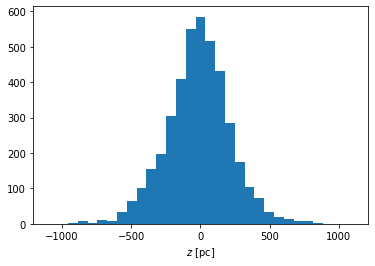

In [14]:
plt.hist(galcen.z.value, bins=np.linspace(-1100, 1100, 32))
plt.xlabel('$z$ [{0:latex_inline}]'.format(galcen.z.unit));

Similarly, for the velocity components, we can use `.v_x`, `.v_y`, and `.v_z`. For example, to create a classic "UV" plane velocity plot:

Text(0, 0.5, '$v_y$ [$\\mathrm{km\\,s^{-1}}$]')

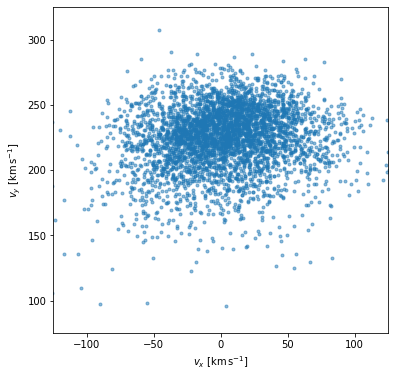

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(galcen.v_x.value, galcen.v_y.value,
        marker='.', linestyle='none', alpha=0.5)

ax.set_xlim(-125, 125)
ax.set_ylim(200-125, 200+125)

ax.set_xlabel('$v_x$ [{0:latex_inline}]'.format(u.km/u.s))
ax.set_ylabel('$v_y$ [{0:latex_inline}]'.format(u.km/u.s))

Along with astrometric and radial velocity data, `Gaia` also provides photometric data for three photometric bandpasses: the broad-band `G`, the blue `BP`, and the red `RP` magnitudes. Let's make a Gaia color-magnitude diagram using the $G_{\rm BP}-G_{\rm RP}$ color and the absolute $G$-band magnitude $M_G$. We'll compute the absolute magnitude using the distances we computed earlier — Astropy `Distance` objects have a convenient `.distmod` attribute that provides the distance modulus:

In [16]:
M_G = gaia_data['phot_g_mean_mag'] - dist.distmod
BP_RP = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']

Text(0, 0.5, '$M_G$')

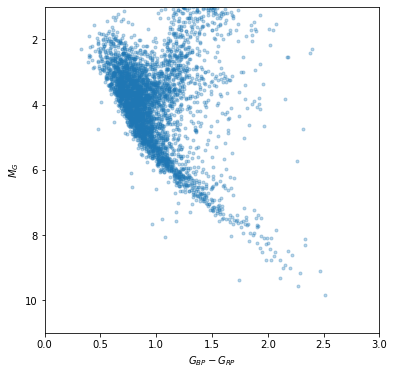

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(BP_RP.value, M_G.value, 
        marker='.', linestyle='none', alpha=0.3)

ax.set_xlim(0, 3)
ax.set_ylim(11, 1)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

In the above, there is a wide range of main sequence star masses which have a range of lifetimes. The most massive stars were likely born in the thin disk and their orbits therefore likely have smaller vertical amplitudes than the typical old main sequence star. To compare, we'll create two sub-selections of the Gaia CMD to select massive and low-mass main sequence stars from the CMD for comparison. You may see two ``RuntimeWarning``(s) from running the next cell — these are expected and it's safe to ignore them.

In [18]:
np.seterr(invalid="ignore")
hi_mass_mask = ((BP_RP > 0.5*u.mag) & (BP_RP < 0.7*u.mag) & 
                (M_G > 2*u.mag) & (M_G < 3.75*u.mag) & 
                (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))

lo_mass_mask = ((BP_RP > 2*u.mag) & (BP_RP < 2.4*u.mag) & 
                (M_G > 8.2*u.mag) & (M_G < 9.7*u.mag) &
                (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))

Let's also define default colors to use when visualizing the high- and low-mass stars:

In [19]:
hi_mass_color = '#2f2d52' #tab:red
lo_mass_color = '#85bd76'

Let's now visualize these two CMD selections:

Text(0, 0.5, '$M_G$')

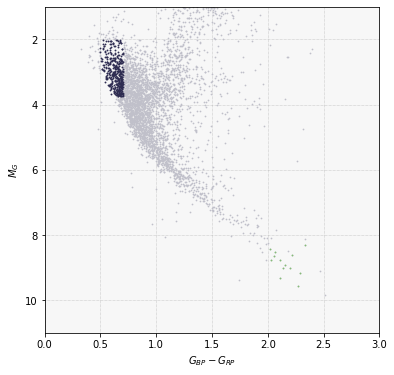

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

#ax.plot(BP_RP.value, M_G.value, 
 #       marker='.', linestyle='none', alpha=0.1)

ax.errorbar(BP_RP.value, M_G.value, 
        fmt='.', color='#c0c0ca', markersize=1.5)

for mask, color in zip([lo_mass_mask, hi_mass_mask],
                       [lo_mass_color, hi_mass_color]):
   # ax.plot(BP_RP[mask].value, M_G[mask].value, 
    #        marker='.', linestyle='none', 
     #       alpha=0.5, color=color)
    ax.errorbar(BP_RP[mask].value, M_G[mask].value, fmt='.', zorder=10, color=color, markersize=1.5)

ax.set_facecolor('#F7F7F7')
ax.grid(True, color='#9999993c', linestyle=':', linewidth=0.5)
ax.set_xlim(0, 3)
ax.set_ylim(11, 1)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')


#fig.savefig('CMD_Mass_Original_Gala.pdf',format="pdf",dpi=300,pad_inches = 0,\
 #           bbox_inches='tight' )

Thus far, we've used the color-magnitude diagram (using parallaxes and photometry from Gaia to compute absolute magnitudes) to select samples of high- and low-mass stars based on their colors.

In what follows, we'll compute Galactic orbits for stars in the high- and low-mass star selections above and compare.

## Using `gala` to numerically integrate Galactic stellar orbits

`gala` is an Astropy affiliated package for Galactic dynamics. `gala` provides functionality for representing analytic mass models that are commonly used in Galactic dynamics contexts for numerically integrating stellar orbits. For examples, see Chapter 3 of Binney and Tremaine (2008). The gravitational potential models are defined by specifying parameters like mass, scale radii, or shape parameters and can be combined. Once defined, they can be used in combination with numerical integrators provided in `gala` to compute orbits. `gala` comes with a pre-defined, multi-component, but [simple model for the Milky Way](http://gala.adrian.pw/en/latest/potential/define-milky-way-model.html) that can be used for orbit integrations. Let's create an instance of the `MilkyWayPotential` model and integrate orbits for the high- and low-mass main sequence stars selected above:

In [21]:
milky_way = gp.MilkyWayPotential()
milky_way

<CompositePotential disk,bulge,nucleus,halo>

This model has mass components for the Galactic disk, bulge, nucleus, and halo, and the parameters were defined by fitting measurements of the Milky Way enclosed mass at various radii. See [this document](http://gala.adrian.pw/en/latest/potential/define-milky-way-model.html) for more details. The parameters of the `MilkyWayPotential` can be changed by passing in a dictionary of parameter values to argument names set by the component names. For example, to change the disk mass to make it slightly more massive (the choice `8e10` is arbitrary!):

In [22]:
different_disk_potential = gp.MilkyWayPotential(disk=dict(m=8e10*u.Msun))
different_disk_potential

<CompositePotential disk,bulge,nucleus,halo>

To integrate orbits, we have to combine the mass model with a reference frame into a `Hamiltonian` object. If no reference frame is passed in, it's assumed that we are in a static inertial frame moving with the center of the mass model:

In [23]:
H = gp.Hamiltonian(milky_way)

Now that we have the mass model, we can integrate orbits. Let's now define initial conditions for subsets of the high- and low-mass star selections we did above. Initial conditions in `gala` are specified by creating `PhaseSpacePosition` objects. We can create these objects directly from a `Galactocentric` object, like we have defined above from transforming the Gaia data — we first have to extract the data with a Cartesian representation. We can do this by calling `galcen.cartesian`:

In [24]:
w0_hi = gd.PhaseSpacePosition(galcen[hi_mass_mask].cartesian)
w0_lo = gd.PhaseSpacePosition(galcen[lo_mass_mask].cartesian)
w0_hi.shape, w0_lo.shape

((406,), (13,))

From the above, we can see that we have 185 high-mass star and 577 low-mass stars in our selections. To integrate orbits, we call the `.integrate_orbit()` method on the Hamiltonian object we defined above, and pass in initial conditions. We also have to specify the timestep for integration, and how long we want to integrate for. We can do this by either specifying the amount of time to integrate for, or by specifying the number of timesteps. Let's specify a timestep of 1 Myr and a time of 500 Myr (approximately two revolutions around the Galaxy for a Sun-like orbit):

In [25]:
orbits_hi = H.integrate_orbit(w0_hi, dt=1*u.Myr, 
                              t1=0*u.Myr, t2=500*u.Myr)

orbits_lo = H.integrate_orbit(w0_lo, dt=1*u.Myr, 
                              t1=0*u.Myr, t2=500*u.Myr)

By default this uses a [Leapfrog](https://en.wikipedia.org/wiki/Leapfrog_integration) numerical integration scheme, but the integrator can be customized — see the `gala` [examples](http://gala.adrian.pw/en/latest/examples/integrate-potential-example.html) for more details.

With the orbit objects in hand, we can continue our comparison of the orbits of high-mass and low-mass main sequence stars in the solar neighborhood. Let's start by plotting a few orbits. The `.plot()` convenience function provides a quick way to visualize orbits in three Cartesian projections. For example, let's plot the first orbit in each subsample on the same figure:

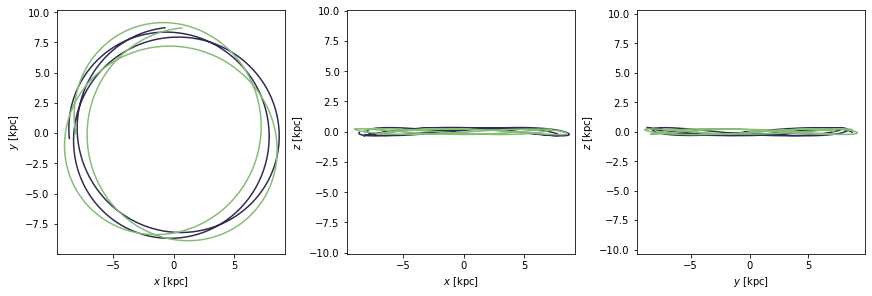

In [26]:
fig = orbits_hi[:, 0].plot(color=hi_mass_color)
_ = orbits_lo[:, 0].plot(axes=fig.axes, color=lo_mass_color)

Note in the above figure that the orbits are almost constrained to the x-y plane: the excursions are much larger in the x and y directions as compared to the z direction.

The default plots show all Cartesian projections. This can be customized to, for example, only show specified components (including velocity components):

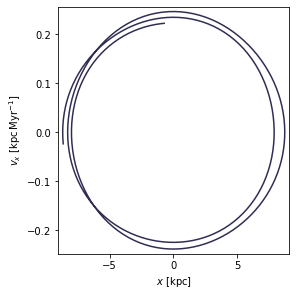

In [27]:
fig = orbits_hi[:, 0].plot(['x', 'v_x'], 
                           auto_aspect=False, 
                           color=hi_mass_color)

The representation can also be changed, for example, to a cylindrical representation:

(-0.3, 0.3)

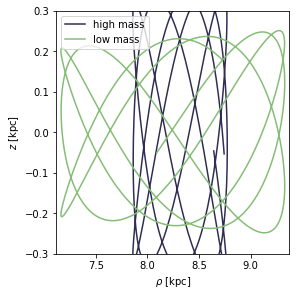

In [28]:
fig = orbits_hi[:, 0].cylindrical.plot(['rho', 'z'], 
                                       color=hi_mass_color,
                                       label='high mass')
_ = orbits_lo[:, 0].cylindrical.plot(['rho', 'z'], color=lo_mass_color,
                                     axes=fig.axes,
                                     label='low mass')

fig.axes[0].legend(loc='upper left')
fig.axes[0].set_ylim(-0.3, 0.3)

Already in the above plot we can see that the high-mass star has an orbit with smaller eccentricity (smaller radial variations) and smaller vertical oscillations as compared to the low-mass star. Below, we'll quantify this and look at the vertical excursions of all of the high- and low-mass stars, respectively.

Let's now compare the vertical amplitudes of the orbits in each of our sub-selections! We can compute the (approximate) maximum vertical height of each orbit using the convenience method `.zmax()` (you can see a list of all convenience methods on the `Orbit` object [in the Gala documentation here](http://gala.adrian.pw/en/latest/api/gala.dynamics.Orbit.html#gala.dynamics.Orbit)):

In [29]:
zmax_hi = orbits_hi.zmax(approximate=True)
zmax_lo = orbits_lo.zmax(approximate=True)

Let's make histograms of the maximum $z$ heights for these two samples:

Text(0.5, 0, '$z_{\\rm max}$ [$\\mathrm{kpc}$]')

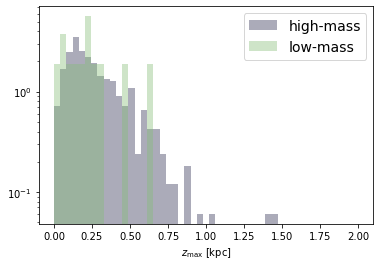

In [30]:
bins = np.linspace(0, 2, 50)

plt.hist(zmax_hi.value, bins=bins, 
         alpha=0.4, density=True, label='high-mass', 
         color=hi_mass_color)
plt.hist(zmax_lo.value, bins=bins, 
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$z_{\rm max}$" + " [{0:latex}]".format(zmax_hi.unit))

The distribution of $z$-heights for the low-mass (i.e. typically older) stars is more extended, as we predicted!

In this tutorial, we've used `astroquery` to query the Gaia science archive to retrieve kinematic and photometric data for a small sample of stars with well-measured parallaxes from Gaia DR2. We used the colors and absolute magnitudes of these stars to select subsamples of high- and low-mass stars, which, on average, will provide us with subsamples of stars that are younger and older, respectively. We then constructed a model for the gravitational field of the Milky Way and numerically integrated the orbits of all stars in each of the two subsamples. Finally, we used the orbits to compute the maximum height that each star reaches above the Galactic midplane and showed that the younger (higher-mass) stars tend to have smaller excursions from the Galactic plane, consistent with the idea that stars are either born in a "thinner" disk and dynamically "heated," or that older stars formed with a larger vertical scale-height.

## Exercises

1. Some of the low-mass star orbits have large vertical excursions from the Galactic disk (up to and above 1.5 kpc) and could therefore be stellar halo stars rather than part of the Galactic disk. Use the zmax values to select a few of these stars and plot their full orbits. Do these stars look like they are part of the disk? Why / why not?
2. [Orbit](http://gala.adrian.pw/en/latest/dynamics/orbits-in-detail.html) objects also provide methods for computing apocenter and pericenter distances and eccentricities. Which types of stars (high-mass or low-mass) tend to have high eccentricity orbits within the Galaxy? Similar to the plot above, make a plot showing the two distributions of eccentricity values.

In [31]:
orbits_hi.eccentricity() 

<Quantity [0.05480409, 0.14157766, 0.10606802, 0.11208019, 0.09997259,
           0.07741137, 0.1357452 , 0.22915562, 0.32455364, 0.10779359,
           0.02453332, 0.15060608, 0.20534644, 0.17034137, 0.11510312,
           0.08423798, 0.10676407, 0.12100794, 0.02915926, 0.06776906,
           0.02294756, 0.12810226, 0.13006354, 0.07113505, 0.08732676,
           0.0331305 , 0.05749734, 0.15791859, 0.11163671, 0.05042102,
           0.20976357, 0.1954396 , 0.05156335, 0.1418775 , 0.28371464,
           0.09752499, 0.04308221, 0.1008751 , 0.14671463, 0.14266137,
           0.07838126, 0.14111412, 0.06258136, 0.09247629, 0.07415472,
           0.26101902, 0.0319862 , 0.18832718, 0.01278699, 0.13425802,
           0.07009728, 0.15707726, 0.05316342, 0.08092141, 0.07662716,
           0.04802253, 0.15801221, 0.07815272, 0.12407178, 0.06201169,
           0.1124998 , 0.0891343 , 0.07404691, 0.10809462, 0.10122963,
           0.18159024, 0.1222119 , 0.03806662, 0.10257162, 0.11239505,
      

In [32]:
np.mean(orbits_hi.kinetic_energy())

<Quantity 0.02782586 kpc2 / Myr2>

In [33]:
cyl_orbit = orbits_hi.represent_as('cylindrical')
np.mean(cyl_orbit.v_z)

<Quantity 2.77798818e-05 kpc / Myr>

Milky Way potential by Gala

In [34]:
from astropy.io import ascii
tbl = ascii.read('MW_mass_enclosed.csv')

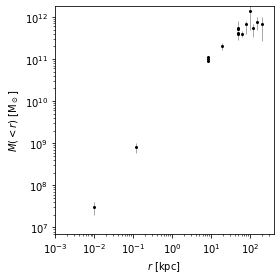

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.errorbar(tbl['r'], tbl['Menc'], yerr=(tbl['Menc_err_neg'],
                                         tbl['Menc_err_pos']),
            marker='o', markersize=2, color='k', alpha=1., ecolor='#aaaaaa',
            capthick=0, linestyle='none', elinewidth=1.)

ax.set_xlim(1E-3, 10**2.6)
ax.set_ylim(7E6, 10**12.25)

ax.set_xlabel('$r$ [kpc]')
ax.set_ylabel('$M(<r)$ [M$_\odot$]')

ax.set_xscale('log')
ax.set_yscale('log')

fig.tight_layout()

In [36]:
def get_potential(log_M_h, log_r_s, log_M_n, log_a):
    mw_potential = gp.CCompositePotential()
    mw_potential['bulge'] = gp.HernquistPotential(m=5E9, c=1., units=galactic)
    mw_potential['disk'] = gp.MiyamotoNagaiPotential(m=6.8E10*u.Msun, a=3*u.kpc, b=280*u.pc,
                                                     units=galactic)
    mw_potential['nucl'] = gp.HernquistPotential(m=np.exp(log_M_n), c=np.exp(log_a)*u.pc,
                                                 units=galactic)
    mw_potential['halo'] = gp.NFWPotential(m=np.exp(log_M_h), r_s=np.exp(log_r_s), units=galactic)

    return mw_potential

In [37]:
# Initial guess for the parameters- units are:
#     [Msun, kpc, Msun, pc]
x0 = [np.log(6E11), np.log(20.), np.log(2E9), np.log(100.)]
init_potential = get_potential(*x0)

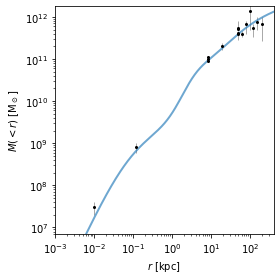

In [38]:
xyz = np.zeros((3, 256))
xyz[0] = np.logspace(-3, 3, 256)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.errorbar(tbl['r'], tbl['Menc'], yerr=(tbl['Menc_err_neg'], tbl['Menc_err_pos']),
            marker='o', markersize=2, color='k', alpha=1., ecolor='#aaaaaa',
            capthick=0, linestyle='none', elinewidth=1.)

fit_menc = init_potential.mass_enclosed(xyz*u.kpc)
ax.loglog(xyz[0], fit_menc.value, marker='', color="#3182bd",
          linewidth=2, alpha=0.7)

ax.set_xlim(1E-3, 10**2.6)
ax.set_ylim(7E6, 10**12.25)

ax.set_xlabel('$r$ [kpc]')
ax.set_ylabel('$M(<r)$ [M$_\odot$]')

ax.set_xscale('log')
ax.set_yscale('log')

fig.tight_layout()

Text(0, 0.5, '$M(<r)$ [$\\mathrm{M_{\\odot}}$]')

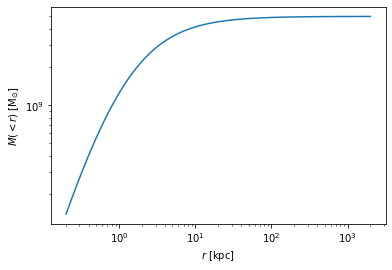

In [39]:
bulge_nuc = gp.HernquistPotential(m=5E9, c=1., units=galactic)
pos = np.zeros((3,100)) * u.kpc
pos[0] = np.logspace(np.log10(20./100.), np.log10(20*100.), pos.shape[1]) * u.kpc
m_profile_bulge_nuc = bulge_nuc.mass_enclosed(pos)
plt.loglog(pos[0], m_profile_bulge_nuc, marker='') 
plt.xlabel("$r$ [{}]".format(pos.unit.to_string(format='latex'))) 
plt.ylabel("$M(<r)$ [{}]".format(m_profile_bulge_nuc.unit.to_string(format='latex'))) 

Text(0, 0.5, '$M(<r)$ [$\\mathrm{M_{\\odot}}$]')

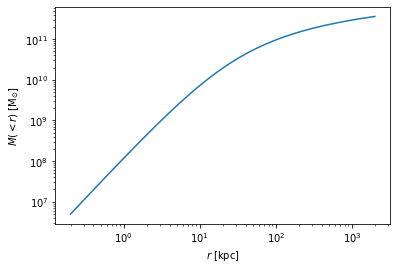

In [40]:
Halo_pot = gp.NFWPotential(m=1E11*u.Msun, r_s=20.*u.kpc, units=galactic)
pos = np.zeros((3,100)) * u.kpc
pos[0] = np.logspace(np.log10(20./100.), np.log10(20*100.), pos.shape[1]) * u.kpc
m_profile_Halo_pot= Halo_pot.mass_enclosed(pos)
plt.loglog(pos[0], m_profile_Halo_pot, marker='') 
ax.errorbar(tbl['r'], tbl['Menc'], yerr=(tbl['Menc_err_neg'], tbl['Menc_err_pos']),
            marker='o', markersize=2, color='k', alpha=1., ecolor='#aaaaaa',
            capthick=0, linestyle='none', elinewidth=1.)
ax.set_xlim(1E-3, 10**2.6)
ax.set_ylim(7E6, 10**12.25)
plt.xlabel("$r$ [{}]".format(pos.unit.to_string(format='latex'))) 
plt.ylabel("$M(<r)$ [{}]".format(m_profile_Halo_pot.unit.to_string(format='latex'))) 

Text(0, 0.5, '$M(<r)$ [$\\mathrm{M_{\\odot}}$]')

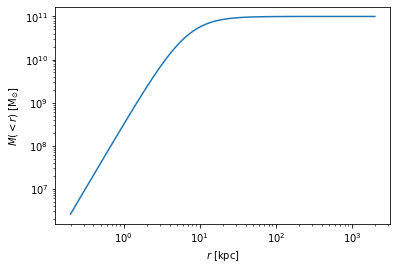

In [41]:
Disk_pot = gp.MiyamotoNagaiPotential(m=1E11, a=6.5, b=0.27, units=galactic)
fig, ax = plt.subplots() 
#p.plot_contours(grid=(np.linspace(-15,15,100), 0., 1.), marker='', ax=ax) 
#E_unit = p.units['energy'] / p.units['mass']
#ax.set_xlabel("$x$ [{}]".format(p.units['length'].to_string(format='latex'))) 
#ax.set_ylabel("$\Phi(x,0,1)$ [{}]".format(E_unit.to_string(format='latex'))) 


pos = np.zeros((3,100)) * u.kpc
pos[0] = np.logspace(np.log10(20./100.), np.log10(20*100.), pos.shape[1]) * u.kpc
m_profile_Disk = Disk_pot.mass_enclosed(pos)
plt.loglog(pos[0], m_profile_Disk, marker='') 
plt.xlabel("$r$ [{}]".format(pos.unit.to_string(format='latex'))) 
plt.ylabel("$M(<r)$ [{}]".format(m_profile_Disk.unit.to_string(format='latex'))) 

In [42]:
#Defining potentials
#Bulge & Nucleus - Hernquist
bulge_nuc = gp.HernquistPotential(m=5E9, c=1., units=galactic)
pos_bulge_nuc = np.zeros((3,100)) * u.kpc
pos_bulge_nuc[0] = np.logspace(np.log10(20./100.), np.log10(20*100.), pos_bulge_nuc.shape[1]) * u.kpc
m_profile_bulge_nuc = bulge_nuc.mass_enclosed(pos_bulge_nuc)
#plt.loglog(pos[0], m_profile_bulge_nuc, marker='') 
#plt.xlabel("$r$ [{}]".format(pos.unit.to_string(format='latex'))) 
#plt.ylabel("$M(<r)$ [{}]".format(m_profile_bulge_nuc.unit.to_string(format='latex'))) 

#Disk
Disk_pot = gp.MiyamotoNagaiPotential(m=1E11, a=6.5, b=0.27, units=galactic)
pos_disk = np.zeros((3,100)) * u.kpc
pos_disk[0] = np.logspace(np.log10(20./100.), np.log10(20*100.), pos_disk.shape[1]) * u.kpc
m_profile_Disk = Disk_pot.mass_enclosed(pos_disk)
#plt.loglog(pos[0], m_profile_Disk, marker='') 
#plt.xlabel("$r$ [{}]".format(pos.unit.to_string(format='latex'))) 
#plt.ylabel("$M(<r)$ [{}]".format(m_profile_Disk.unit.to_string(format='latex'))) 

#Halo
Halo_pot = gp.NFWPotential(m=1E11*u.Msun, r_s=20.*u.kpc, units=galactic)
pos_halo = np.zeros((3,100)) * u.kpc
pos_halo[0] = np.logspace(np.log10(20./100.), np.log10(20*100.), pos_halo.shape[1]) * u.kpc
m_profile_halo= Halo_pot.mass_enclosed(pos_halo)
#plt.loglog(pos[0], m_profile_Halo_pot, marker='') 
#ax.set_xlim(1E-3, 10**2.6)
#ax.set_ylim(7E6, 10**12.25)
#plt.xlabel("$r$ [{}]".format(pos.unit.to_string(format='latex'))) 
#plt.ylabel("$M(<r)$ [{}]".format(m_profile_Halo_pot.unit.to_string(format='latex'))) 


#Milky Way
xyz = np.zeros((3, 256))
xyz[0] = np.logspace(-3, 4, 256)
fit_menc = init_potential.mass_enclosed(xyz*u.kpc)


Text(0.003, 300000000000.0, '(d)')

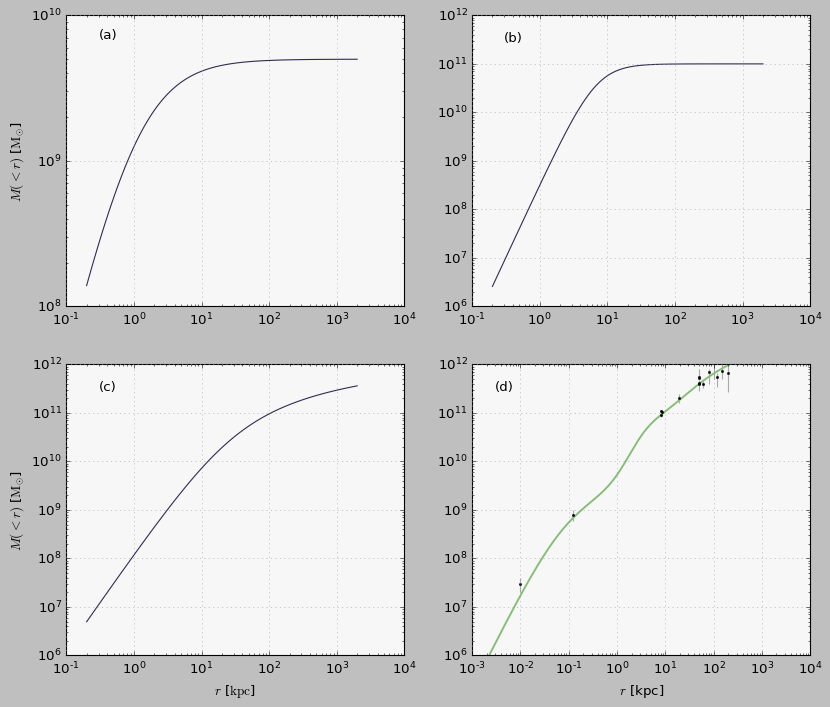

In [43]:


plt.style.use("classic")
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False,\
                         figsize=(12,10), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
#Bulge & Nucleus
axes[0,0].plot(pos_bulge_nuc[0], m_profile_bulge_nuc, linestyle='-', linewidth=1.0, color='#2f2d52', label='Bulge & Nucleus')
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')
#axes[0,0].set_ylim(10**6,10**12)
#axes[0,0].set_xlabel("$r$ [{}]".format(pos_bulge_nuc.unit.to_string(format='latex'))) 
axes[0,0].set_ylabel("$M(<r)$ [{}]".format(m_profile_bulge_nuc.unit.to_string(format='latex'))) 
axes[0,0].grid(True, color='#9999993c', linestyle=':', linewidth=0.5)
axes[0,0].set_facecolor('#F7F7F7')
axes[0,0].text(3e-1,7e9, r'(a)')

#Disk
axes[0,1].plot(pos_disk[0], m_profile_Disk, linestyle='-', linewidth=1.0, color='#2f2d52', label='Disk')
axes[0,1].set_yscale('log')
axes[0,1].set_xscale('log')
#axes[0,1].set_xlabel("$r$ [{}]".format(pos_disk.unit.to_string(format='latex'))) 
#axes[0,1].set_ylabel("$M(<r)$ [{}]".format(m_profile_Disk.unit.to_string(format='latex'))) 
axes[0,1].set_ylim(10**6,10**12)
#axes[0,1].set_xlim(10**(-3),10**4)
axes[0,1].grid(True, color='#9999993c', linestyle=':', linewidth=0.5)
axes[0,1].set_facecolor('#F7F7F7')
axes[0,1].text(3e-1,3e11, r'(b)')

#Halo
axes[1,0].plot(pos_halo[0], m_profile_halo, linestyle='-', linewidth=1.0, color='#2f2d52', label='Disk')
axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].set_xlabel("$r$ [{}]".format(pos_halo.unit.to_string(format='latex'))) 
axes[1,0].set_ylabel("$M(<r)$ [{}]".format(m_profile_halo.unit.to_string(format='latex'))) 
axes[1,0].grid(True, color='#9999993c', linestyle=':', linewidth=0.5)
axes[1,0].set_facecolor('#F7F7F7')
axes[1,0].text(3e-1,3e11, r'(c)')

#Milky Way
axes[1,1].errorbar(tbl['r'], tbl['Menc'], yerr=(tbl['Menc_err_neg'], tbl['Menc_err_pos']),
            marker='o', markersize=2, color='k', alpha=1., ecolor='#aaaaaa',
            capthick=0, linestyle='none', elinewidth=1.)
axes[1,1].plot(xyz[0], fit_menc.value, linestyle='-', linewidth=1.7, color='#85bd76', label='Disk')
axes[1,1].set_xlim(1E-3, 10**4)
axes[1,1].set_ylim(1E6, 10**12)
axes[1,1].set_xlabel('$r$ [kpc]')
#axes[1,1].set_ylabel('$M(<r)$ [M$_\odot$]')
axes[1,1].set_xscale('log')
axes[1,1].set_yscale('log')
axes[1,1].grid(True, color='#9999993c', linestyle=':', linewidth=0.5)
axes[1,1].set_facecolor('#F7F7F7')
axes[1,1].text(3e-3,3e11, r'(d)')

#fig.savefig('Milky_Way_Potential.pdf',format="pdf",dpi=300,pad_inches = 0,\
 #           bbox_inches='tight' )

Sample

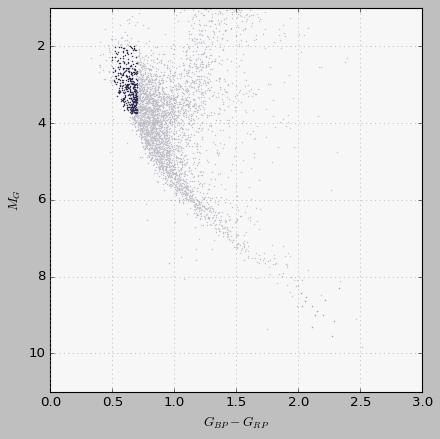

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

#ax.plot(BP_RP.value, M_G.value, 
 #       marker='.', linestyle='none', alpha=0.1)

ax.errorbar(BP_RP.value, M_G.value, 
        fmt='.', color='#c0c0ca', markersize=1.5)

for mask, color in zip([lo_mass_mask, hi_mass_mask],
                       [lo_mass_color, hi_mass_color]):
   # ax.plot(BP_RP[mask].value, M_G[mask].value, 
    #        marker='.', linestyle='none', 
     #       alpha=0.5, color=color)
    ax.errorbar(BP_RP[mask].value, M_G[mask].value, fmt='.', zorder=10, color=color, markersize=1.5)

ax.set_facecolor('#F7F7F7')
ax.grid(True, color='#9999993c', linestyle=':', linewidth=0.5)
ax.set_xlim(0, 3)
ax.set_ylim(11, 1)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')


fig.savefig('CMD_Samle2.pdf',format="pdf",dpi=300,pad_inches = 0,\
            bbox_inches='tight' )

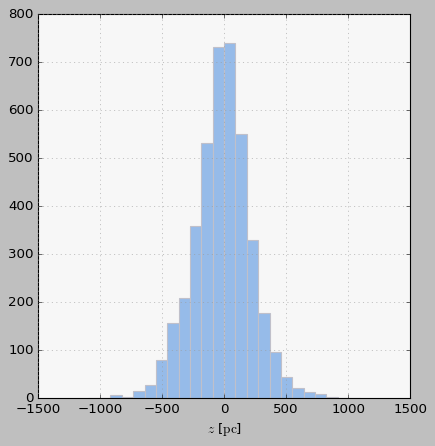

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plt.hist(galcen.z.value, bins=np.linspace(-1100, 1100, 25), color='#96bbe9ff', edgecolor='#c0c0ca')
plt.xlabel('$z$ [{0:latex_inline}]'.format(galcen.z.unit));
ax.set_facecolor('#F7F7F7')
ax.grid(True, color='#9999993c', linestyle=':', linewidth=0.5)

#fig.savefig('DistZ_Sample2.pdf',format="pdf",dpi=300,pad_inches = 0,\
 #           bbox_inches='tight' )

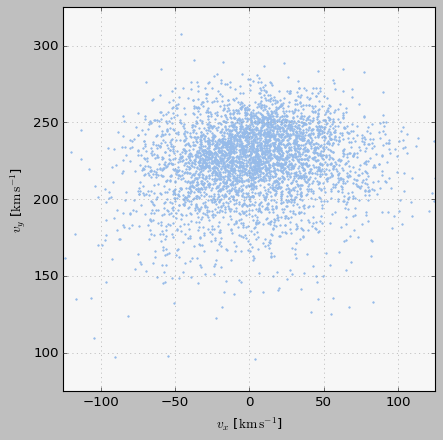

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.errorbar(galcen.v_x.value, galcen.v_y.value, fmt='.', color='#96bbe9ff', markersize=3)

ax.set_xlim(-125, 125)
ax.set_ylim(200-125, 200+125)
ax.set_facecolor('#F7F7F7')
ax.grid(True, color='#9999993c', linestyle=':', linewidth=0.5)

ax.set_xlabel('$v_x$ [{0:latex_inline}]'.format(u.km/u.s))
ax.set_ylabel('$v_y$ [{0:latex_inline}]'.format(u.km/u.s))

fig.savefig('DistVel_Sample2.pdf',format="pdf",dpi=300,pad_inches = 0,\
            bbox_inches='tight' )

Resultados

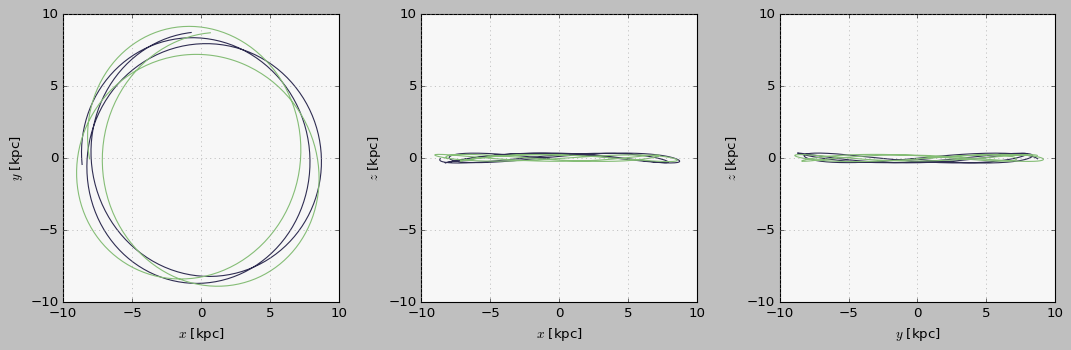

In [59]:
#Coordenadas cartesianas

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False,\
                         figsize=(16,4.5), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

axes[0].plot(orbits_hi.x[:,0],orbits_hi.y[:,0],color=hi_mass_color)
axes[0].plot(orbits_lo.x[:,0],orbits_lo.y[:,0],color=lo_mass_color)
axes[0].set_xlabel(r'$x$ [kpc]')
axes[0].set_ylabel(r'$y$ [kpc]')
axes[0].set_ylim(-10,10)
axes[0].set_facecolor('#F7F7F7')
axes[0].grid(True, color='#9999993c', linestyle=':', linewidth=0.5)


axes[1].plot(orbits_hi.x[:,0],orbits_hi.z[:,0],color=hi_mass_color)
axes[1].plot(orbits_lo.x[:,0],orbits_lo.z[:,0],color=lo_mass_color)
axes[1].set_xlabel(r'$x$ [kpc]')
axes[1].set_ylabel(r'$z$ [kpc]')
axes[1].set_ylim(-10,10)
axes[1].set_facecolor('#F7F7F7')
axes[1].grid(True, color='#9999993c', linestyle=':', linewidth=0.5)


axes[2].plot(orbits_hi.y[:,0],orbits_hi.z[:,0],color=hi_mass_color)
axes[2].plot(orbits_lo.y[:,0],orbits_lo.z[:,0],color=lo_mass_color)
axes[2].set_xlabel(r'$y$ [kpc]')
axes[2].set_ylabel(r'$z$ [kpc]')
axes[2].set_ylim(-10,10)
axes[2].set_facecolor('#F7F7F7')
axes[2].grid(True, color='#9999993c', linestyle=':', linewidth=0.5)


fig.savefig('OrbitPos_Sample2.pdf',format="pdf",dpi=300,pad_inches = 0,\
            bbox_inches='tight' )


In [48]:
#Coordenadas cilíndricas
cyl_orbits_hi = orbits_hi.represent_as('cylindrical')
cyl_orbits_lo = orbits_lo.represent_as('cylindrical')

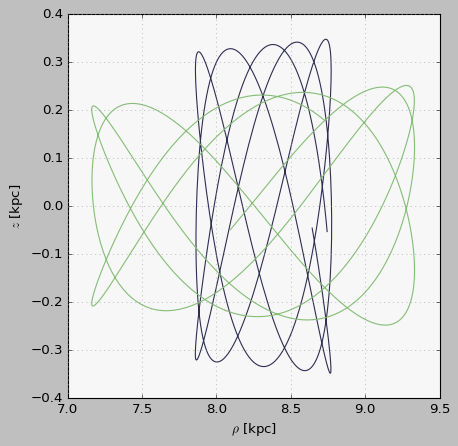

In [60]:
#fig.savefig('OrbitPosCyl_Sample1.pdf',format="pdf",dpi=300,pad_inches = 0,\
 #           bbox_inches='tight' )

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(cyl_orbits_hi.rho[:,0],cyl_orbits_hi.z[:,0],color=hi_mass_color)
ax.plot(cyl_orbits_lo.rho[:,0],cyl_orbits_lo.z[:,0],color=lo_mass_color)
#ax.set_xlim(-125, 125)
#ax.set_ylim(200-125, 200+125)
ax.set_facecolor('#F7F7F7')
ax.grid(True, color='#9999993c', linestyle=':', linewidth=0.5)
ax.set_xlabel(r'$\rho$ [kpc]')
ax.set_ylabel(r'$z$ [kpc]')
fig.savefig('OrbitPosCyl_Sample2.pdf',format="pdf",dpi=300,pad_inches = 0,\
            bbox_inches='tight' )
    

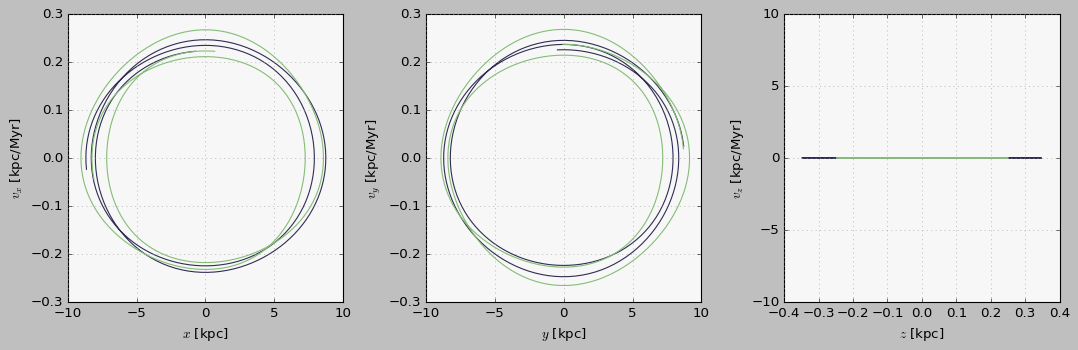

In [61]:
#Velocidades

#Coordenadas cartesianas

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False,\
                         figsize=(16,4.5), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

axes[0].plot(orbits_hi.x[:,0],orbits_hi.v_x[:,0],color=hi_mass_color)
axes[0].plot(orbits_lo.x[:,0],orbits_lo.v_x[:,0],color=lo_mass_color)
axes[0].set_xlabel(r'$x$ [kpc]')
axes[0].set_ylabel(r'$v_x$ [kpc/Myr]')
#axes[0].set_ylim(-10,10)
axes[0].set_facecolor('#F7F7F7')
axes[0].grid(True, color='#9999993c', linestyle=':', linewidth=0.5)


axes[1].plot(orbits_hi.y[:,0],orbits_hi.v_y[:,0],color=hi_mass_color)
axes[1].plot(orbits_lo.y[:,0],orbits_lo.v_y[:,0],color=lo_mass_color)
axes[1].set_xlabel(r'$y$ [kpc]')
axes[1].set_ylabel(r'$v_y$ [kpc/Myr]')
#axes[1].set_ylim(-10,10)
axes[1].set_facecolor('#F7F7F7')
axes[1].grid(True, color='#9999993c', linestyle=':', linewidth=0.5)


axes[2].plot(orbits_hi.z[:,0],orbits_hi.v_z[:,0],color=hi_mass_color)
axes[2].plot(orbits_lo.z[:,0],orbits_lo.v_z[:,0],color=lo_mass_color)
axes[2].set_xlabel(r'$z$ [kpc]')
axes[2].set_ylabel(r'$v_z$ [kpc/Myr]')
axes[2].set_ylim(-10,10)
axes[2].set_facecolor('#F7F7F7')
axes[2].grid(True, color='#9999993c', linestyle=':', linewidth=0.5)


fig.savefig('Vel_Sample2.pdf',format="pdf",dpi=300,pad_inches = 0,\
            bbox_inches='tight' )


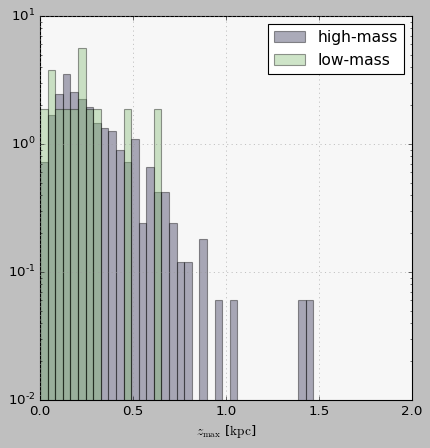

In [62]:
#Zmax
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
zmax_hi = orbits_hi.zmax(approximate=True)
zmax_lo = orbits_lo.zmax(approximate=True)

bins = np.linspace(0, 2, 50)

plt.hist(zmax_hi.value, bins=bins, 
         alpha=0.4, density=True, label='high-mass', 
         color=hi_mass_color)
plt.hist(zmax_lo.value, bins=bins, 
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)
ax.set_facecolor('#F7F7F7')
ax.grid(True, color='#9999993c', linestyle=':', linewidth=0.5)


plt.yscale('log')
plt.xlabel(r"$z_{\rm max}$" + " [{0:latex}]".format(zmax_hi.unit))

fig.savefig('DistZmaxOrbit_Sample2.pdf',format="pdf",dpi=300,pad_inches = 0,\
            bbox_inches='tight' )


In [52]:
#Dynamics

#Angular Momentum
Lz_hi=orbits_hi.angular_momentum()
Lz_lo=orbits_lo.angular_momentum()
#Apocenter
apoc_hi=orbits_hi.apocenter()
apoc_lo=orbits_lo.apocenter()
#Eccentricity
ecc_hi=orbits_hi.eccentricity()
ecc_lo=orbits_lo.eccentricity()
#Kinetic energy
KE_hi=orbits_hi.kinetic_energy()
KE_lo=orbits_lo.kinetic_energy()
#Period
period_hi=orbits_hi.estimate_period()
period_lo=orbits_lo.estimate_period()
#Pericenter
per_hi=orbits_hi.pericenter()
per_lo=orbits_lo.pericenter()
#Zmax
zmax_hi=orbits_hi.zmax()
zmax_lo=orbits_lo.zmax()

#Velocity
vel_hi=np.sqrt(2*KE_hi)
vel_lo=np.sqrt(2*KE_lo)

In [53]:
#Angular momentum
mLz_hi=np.mean(Lz_hi)
sLz_hi=np.std(Lz_hi)
mLz_lo=np.mean(Lz_lo)
sLz_lo=np.std(Lz_lo)

#Apocenter
mapoc_hi=np.mean(apoc_hi)
sapoc_hi=np.std(apoc_hi)
mapoc_lo=np.mean(apoc_lo)
sapoc_lo=np.std(apoc_lo)

#Eccentricity
mecc_hi=np.mean(ecc_hi)
secc_hi=np.std(ecc_hi)
mecc_lo=np.mean(ecc_lo)
secc_lo=np.std(ecc_lo)

#Kinetic energy
mKE_hi=np.mean(KE_hi)
sKE_hi=np.std(KE_hi)
mKE_lo=np.mean(KE_lo)
sKE_lo=np.std(KE_lo)

#Period
mperiod_hi=np.mean(period_hi)
speriod_hi=np.std(period_hi)
mperiod_lo=np.mean(period_lo)
speriod_lo=np.std(period_lo)

#Pericenter
mper_hi=np.mean(per_hi)
sper_hi=np.std(per_hi)
mper_lo=np.mean(per_lo)
sper_lo=np.std(per_lo)

#Zmax
mzmax_hi=np.mean(zmax_hi)
szmax_hi=np.std(zmax_hi)
mzmax_lo=np.mean(zmax_lo)
szmax_lo=np.std(zmax_lo)

#Velocity
mvel_hi=np.mean(vel_hi)
svel_hi=np.std(vel_hi)
mvel_lo=np.mean(vel_lo)
svel_lo=np.std(vel_lo)

In [54]:
from astropy.table import QTable, Table, Column

properties=['Lz', 'Apoc', 'Ecc', 'KE', 'Period', 'Peric', 'Zmax', 'Vel']
mean_hi=[mLz_hi, mapoc_hi, mecc_hi, mKE_hi, mperiod_hi, mper_hi, mzmax_hi, mvel_hi]
std_hi=[sLz_hi, sapoc_hi, secc_hi, sKE_hi, speriod_hi, sper_hi, szmax_hi, svel_hi]
mean_lo=[mLz_lo, mapoc_lo, mecc_lo, mKE_lo, mperiod_lo, mper_lo, mzmax_lo, mvel_lo]
std_lo=[sLz_lo, sapoc_lo, secc_lo, sKE_lo, speriod_lo, sper_lo, szmax_lo, svel_lo]

t = Table([properties, mean_hi, std_hi, mean_lo, std_lo], names=('properties', 'mean_hi', 'std_hi', 'mean_lo', 'std_lo'))
t

properties,mean_hi,std_hi,mean_lo,std_lo
str6,object,object,object,object
Lz,-0.6432085753171247 kpc2 / Myr,0.9174249498398398 kpc2 / Myr,-0.6264473646216352 kpc2 / Myr,0.8910856577569153 kpc2 / Myr
Apoc,9.21107741350362 kpc,1.024854342504414 kpc,9.451001349647385 kpc,1.0073350014581546 kpc
Ecc,0.10894665428325362,0.05971629824124773,0.15671193319518334,0.07812489292966941
KE,0.027825858796212976 kpc2 / Myr2,0.0049180932778398615 kpc2 / Myr2,0.028267355455581927 kpc2 / Myr2,0.007003680040134152 kpc2 / Myr2
Period,162.35652709359607 Myr,16.017197686783355 Myr,159.55128205128204 Myr,13.13386609217883 Myr
Peric,7.39104333263651 kpc,0.7408978982684314 kpc,6.886801089700766 kpc,0.7851415692339484 kpc
Zmax,0.283646422683043 kpc,0.20376492606249422 kpc,0.21848641592316465 kpc,0.1613613423875912 kpc
Vel,0.23498589051126068 kpc / Myr,0.0208170327629989 kpc / Myr,0.2359502645017054 kpc / Myr,0.029362962942099766 kpc / Myr
